<h1>Retired People and “Retired Places”: Italy, Data Cleaning<span class="tocSkip"></span></h1>
<div class="toc">
  <ol class="toc-item">
    <li>
      <span>
        <a href="#Loading-raw-tables" data-toc-modified-id="Loading-raw-tables-1">
          <span class="toc-item-num"></span>Loading raw tables
        </a>
      </span>
    </li>
    <li>
      <span>
        <a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-2">
          <span class="toc-item-num"></span>Data cleaning 
        </a>
      </span>
    </li>
  </ol>
</div>





## Loading raw tables <a id="Loading-raw-tables"></a>


In [1]:
import pandas as pd
from pathlib import Path
import geopandas as gpd

print('Libraries are downloaded')

Libraries are downloaded


In [2]:
PROJECT_ROOT = Path("..").resolve().parent
RAW = PROJECT_ROOT / "data" / "raw"

# path for cleaned data
PROCESSED = PROJECT_ROOT / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

In [3]:
pop_reg_it = pd.read_csv(
    RAW / "popolazione_2025_it_regioni.csv",  
    sep=";",        
    skiprows=1,    
    encoding="utf-8"
)
display(pop_reg_it.head())

,Codice regione,Regione,Età,Totale maschi,Totale femmine,Totale
0,13,Abruzzo,0.0,3842.0,3577.0,7419.0
1,13,Abruzzo,1.0,4010.0,3653.0,7663.0
2,13,Abruzzo,2.0,4260.0,3873.0,8133.0
3,13,Abruzzo,3.0,4298.0,4163.0,8461.0
4,13,Abruzzo,4.0,4456.0,4163.0,8619.0


In [4]:
# load raw Excel without headers to inspect structure
homes_raw = pd.read_excel(
    RAW / "abitazioni_occupate_non_occupate_reg.xlsx",
    sheet_name=0,
    header=None
)

display(homes_raw.head(15))


,0,1,2,3
0,Abitazioni occupate e non occupate - comuni,NaN,NaN,NaN
1,Frequenza: Annuale,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,Anno,2021,2021,2021
4,Indicatore,Abitazioni occupate al 31 dicembre,Abitazioni non occupate al 31 dicembre,Abitazioni al 31 dicembre
5,Anno base,,,
6,Unità di misura,,,
7,Unità di moltiplicazione,,,
8,Territorio,,,
9,Piemonte,1964108,827768,2791876


In [5]:
gdf = gpd.read_file(RAW / "Reg01012025_g_WGS84.shp")
gdf.to_file("italy_regions.geojson", driver="GeoJSON")

gdf.head()

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry
0,1,1,Piemonte,1.204253e+06,2.538884e+10,"POLYGON ((457423.465 5145719.795, 457503.63 51..."
1,1,2,Valle d'Aosta,3.068811e+05,3.260045e+09,"POLYGON ((389617.651 5093644.156, 389835.65 50..."
2,1,3,Lombardia,1.380027e+06,2.386128e+10,"MULTIPOLYGON (((485366.17 4984899.483, 485306...."
3,2,4,Trentino-Alto Adige,7.818018e+05,1.360618e+10,"POLYGON ((743539.748 5219742.292, 744116.845 5..."
4,2,5,Veneto,1.033420e+06,1.835382e+10,"POLYGON ((768720.205 5175392.996, 769182.105 5..."


In [6]:
# check that all regions are present
gdf.shape

(20, 6)

Check the current Coordinate Reference System (CRS). This is important because most web maps and GeoJSON files expect WGS84 (EPSG:4326). If the shapefile is in a different CRS (e.g. UTM), we need to reproject it before exporting and using it in the Streamlit choropleth map.

In [7]:
gdf.crs


<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# Reproject the shapefile to WGS84 (EPSG:4326), i.e. latitude/longitude in degrees.
# Web maps and most GeoJSON-based tools expect coordinates in EPSG:4326,
# not in projected systems like UTM (EPSG:32632), which use metres.
gdf_4326 = gdf.to_crs(epsg=4326)

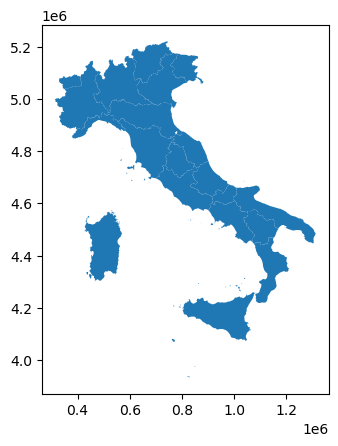

In [9]:
gdf.plot();


In [10]:
# Export the reprojected layer to GeoJSON.
out_path = PROCESSED / "italy_regions.geojson"
gdf_4326.to_file(out_path, driver="GeoJSON")

print(f"saved to: {out_path}")

saved to: /Users/eugenia/Desktop/Open Access/project/retired_places/data/processed/italy_regions.geojson


In [11]:
gdf_places_centre = gpd.read_file(RAW / "center" / "gis_osm_places_free_1.shp")

In [12]:
gdf_places_centre.tail()

,osm_id,code,fclass,population,name,geometry
23350,13314114468,1004,hamlet,0,Morrice,POINT (13.3902 42.76996)
23351,13327621562,1050,locality,0,Monte Pedragozzoli,POINT (11.53655 44.03869)
23352,13340852303,1050,locality,0,Pianello,POINT (10.3214 43.9853)
23353,13340852309,1050,locality,0,L'Orso,POINT (10.32715 43.98733)
23354,13347626115,1050,locality,0,Alle Capanne,POINT (10.53107 43.76817)


In [36]:
gdf_places_centre.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

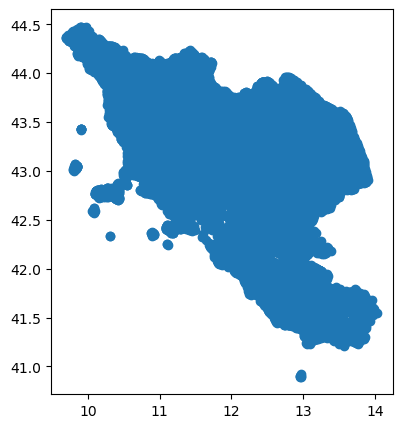

In [13]:
gdf_places_centre.plot(figsize=(5, 5))

In [14]:
gdf_places_islands = gpd.read_file(RAW / "islands" / "gis_osm_places_free_1.shp")

gdf_places_islands.head()

,osm_id,code,fclass,population,name,geometry
0,67253662,1001,city,628165,Palermo,POINT (13.35244 38.11123)
1,67253674,1001,city,55286,Agrigento,POINT (13.57465 37.3123)
2,67253682,1001,city,58283,Caltanissetta,POINT (14.06328 37.49026)
3,67253693,1001,city,298037,Catania,POINT (15.08737 37.50236)
4,67253701,1001,city,216918,Messina,POINT (15.55421 38.19376)


In [37]:
gdf_places_islands.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

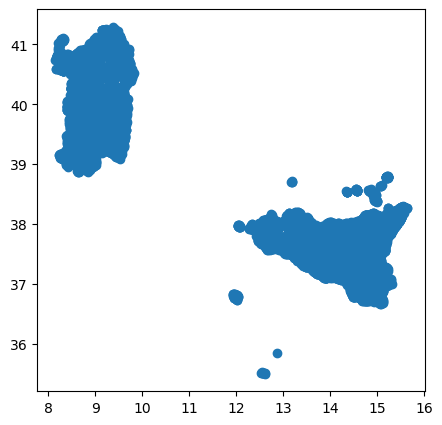

In [15]:
gdf_places_islands.plot(figsize=(5, 5))

In [16]:
gdf_places_ne = gpd.read_file(RAW / "north-east" / "gis_osm_places_free_1.shp")

gdf_places_ne.head()

,osm_id,code,fclass,population,name,geometry
0,29105049,1010,suburb,0,San Pio X,POINT (11.77254 45.07422)
1,29997772,1002,town,87377,Mestre,POINT (12.24181 45.49431)
2,30039369,1010,suburb,19091,Carpenedo,POINT (12.25076 45.50467)
3,30042134,1003,village,0,Sant'Erasmo,POINT (12.39374 45.45334)
4,30043378,1003,village,707,Punta Sabbioni,POINT (12.4276 45.44774)


In [38]:
gdf_places_ne.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

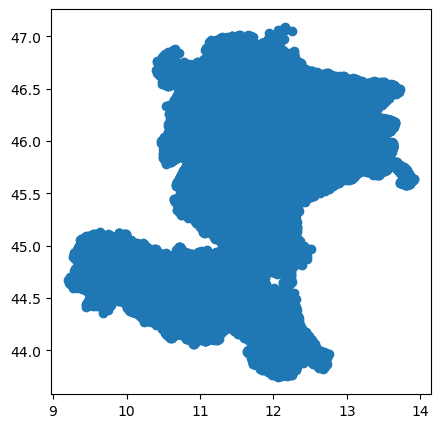

In [17]:
gdf_places_ne.plot(figsize=(5, 5))

In [19]:
gdf_places_nw = gpd.read_file(RAW / "north-west" / "gis_osm_places_free_1.shp")

gdf_places_nw.head()

,osm_id,code,fclass,population,name,geometry
0,59889482,1004,hamlet,0,Poggio,POINT (8.72158 46.0813)
1,59943000,1004,hamlet,0,Virasca,POINT (8.65932 45.94051)
2,60005756,1003,village,0,Folsogno,POINT (8.55015 46.13431)
3,60169984,1003,village,0,Sant'Agata,POINT (8.68572 46.07089)
4,62505581,1001,city,1350000,Milano,POINT (9.18963 45.46419)


In [39]:
gdf_places_nw.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

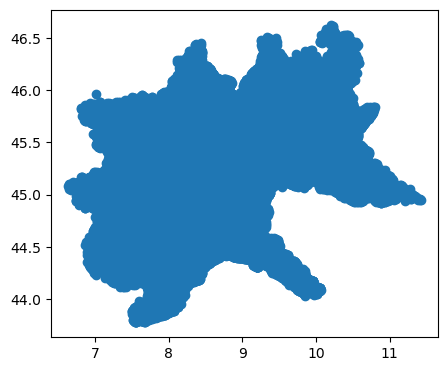

In [20]:
gdf_places_nw.plot(figsize=(5, 5))

In [21]:
gdf_places_south = gpd.read_file(RAW / "south" / "gis_osm_places_free_1.shp")

gdf_places_south.head()

,osm_id,code,fclass,population,name,geometry
0,15419779,1003,village,241,Marina di Sibari,POINT (16.485 39.74528)
1,18114440,1004,hamlet,0,Campizze,POINT (14.59723 41.04922)
2,49804751,1004,hamlet,0,Colle Formica,POINT (13.91179 42.44541)
3,49804933,1004,hamlet,0,Case Bruciate,POINT (13.84683 42.43456)
4,49805354,1010,suburb,0,Ripattoni Nuovo,POINT (14.05954 42.37197)


In [40]:
gdf_places_south.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

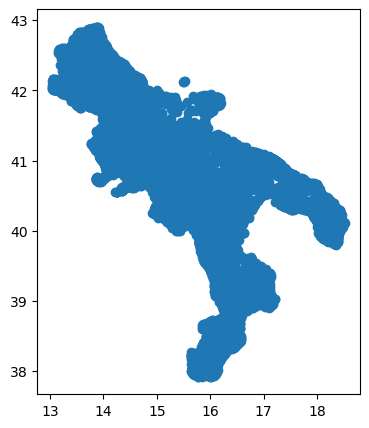

In [22]:
gdf_places_south.plot(figsize=(5, 5))

## Data cleaning <a id="Data-cleaning"></a>


### Adjusting columns names 

In [23]:
# Keep only the data rows starting from the first region 
homes_it_clean = homes_raw.iloc[9:, :4].copy()

# Assign clean column names
homes_it_clean.columns = ["region", "homes_occupied", "homes_unoccupied", "homes_total"]

# Reset index
homes_it_clean = homes_it_clean.reset_index(drop=True)

# Final check
display(homes_it_clean.head())


,region,homes_occupied,homes_unoccupied,homes_total
0,Piemonte,1964108,827768,2791876
1,Valle d'Aosta / Vallée d'Aoste,59616,75948,135564
2,Liguria,746686,431321,1178007
3,Lombardia,4415364,1184728,5600092
4,Trentino Alto Adige / Südtirol,463305,219888,683193


In [24]:
# translare column names to unify the language
pop_reg_it_clean = pop_reg_it.copy()
pop_reg_it_clean.columns = ["region_code", "region", "age", "pop_male", "pop_female", "pop_total"]

pop_reg_it_clean.head()

,region_code,region,age,pop_male,pop_female,pop_total
0,13,Abruzzo,0.0,3842.0,3577.0,7419.0
1,13,Abruzzo,1.0,4010.0,3653.0,7663.0
2,13,Abruzzo,2.0,4260.0,3873.0,8133.0
3,13,Abruzzo,3.0,4298.0,4163.0,8461.0
4,13,Abruzzo,4.0,4456.0,4163.0,8619.0


### Changing data types

In [25]:
print("=== homes_it_clean: dtypes ===")
print(homes_it_clean.dtypes)
print("\n")

print("=== pop_reg_it_clean: dtypes ===")
print(pop_reg_it_clean.dtypes)
print("\n")

print("=== gdf_places_centre: dtypes ===")
print(gdf_places_centre.dtypes)
print("\n")

print("=== gdf_places_south: dtypes ===")
print(gdf_places_south.dtypes)
print("\n")

print("=== gdf_places_islands: dtypes ===")
print(gdf_places_islands.dtypes)
print("\n")

print("=== gdf_places_ne: dtypes ===")
print(gdf_places_ne.dtypes)
print("\n")

print("=== gdf_places_nw: dtypes ===")
print(gdf_places_nw.dtypes)


=== homes_it_clean: dtypes ===
region              object
homes_occupied      object
homes_unoccupied    object
homes_total         object
dtype: object


=== pop_reg_it_clean: dtypes ===
region_code     object
region          object
age            float64
pop_male       float64
pop_female     float64
pop_total      float64
dtype: object


=== gdf_places_centre: dtypes ===
osm_id          object
code             int32
fclass          object
population       int64
name            object
geometry      geometry
dtype: object


=== gdf_places_south: dtypes ===
osm_id          object
code             int32
fclass          object
population       int64
name            object
geometry      geometry
dtype: object


=== gdf_places_islands: dtypes ===
osm_id          object
code             int32
fclass          object
population       int64
name            object
geometry      geometry
dtype: object


=== gdf_places_ne: dtypes ===
osm_id          object
code             int32
fclass          ob

For geo data the data types look appropriate: IDs and class labels are stored as text, the classification code and population are numeric, and the geometries are correctly stored as a geometry column. So we can proceed.

But housing and population information we will unify data types for operability. 

In [26]:
# Housing counts in homes_it  → Int64
housing_numeric_cols = ["homes_occupied", "homes_unoccupied", "homes_total"]

for col in housing_numeric_cols:
    homes_it_clean[col] = (
        pd.to_numeric(homes_it_clean[col], errors="coerce")  
        .round()
        .astype("Int64")                              
    )

# Population counts in pop_reg_it → Int64
population_numeric_cols = ["region_code", "age", "pop_male", "pop_female", "pop_total"]

for col in population_numeric_cols:
    pop_reg_it[col] = (
        pd.to_numeric(pop_reg_it_clean[col], errors="coerce")
        .round()
        .astype("Int64")
    )

print("=== homes_it_clean: dtypes after conversion ===")
print(homes_it_clean.dtypes)
print("\n")
print("=== pop_reg_it_clean: dtypes after conversion ===")
print(pop_reg_it_clean.dtypes)

=== homes_it_clean: dtypes after conversion ===
region              object
homes_occupied       Int64
homes_unoccupied     Int64
homes_total          Int64
dtype: object


=== pop_reg_it_clean: dtypes after conversion ===
region_code     object
region          object
age            float64
pop_male       float64
pop_female     float64
pop_total      float64
dtype: object


### Checking for missing values 

In [27]:

print("=== Missing values in homes_it_clean (absolute counts) ===")
print(homes_it_clean.isna().sum())
print("\n")

print("=== Missing values in pop_reg_it_clean (absolute counts) ===")
print(pop_reg_it_clean.isna().sum())
print("\n")

print("=== Missing values in gdf_places_nw ===")
print(gdf_places_nw.isna().sum())
print("\n")

print("=== Missing values in gdf_places_ne ===")
print(gdf_places_ne.isna().sum())
print("\n")

print("=== Missing values in gdf_places_centre ===")
print(gdf_places_centre.isna().sum())
print("\n")

print("=== Missing values in gdf_places_islands ===")
print(gdf_places_islands.isna().sum())
print("\n")

print("=== Missing values in gdf_places_south ===")
print(gdf_places_south.isna().sum())

=== Missing values in homes_it_clean (absolute counts) ===
region              0
homes_occupied      0
homes_unoccupied    0
homes_total         0
dtype: int64


=== Missing values in pop_reg_it_clean (absolute counts) ===
region_code    0
region         1
age            1
pop_male       1
pop_female     1
pop_total      1
dtype: int64


=== Missing values in gdf_places_nw ===
osm_id          0
code            0
fclass          0
population      0
name          116
geometry        0
dtype: int64


=== Missing values in gdf_places_ne ===
osm_id          0
code            0
fclass          0
population      0
name          145
geometry        0
dtype: int64


=== Missing values in gdf_places_centre ===
osm_id         0
code           0
fclass         0
population     0
name          47
geometry       0
dtype: int64


=== Missing values in gdf_places_islands ===
osm_id         0
code           0
fclass         0
population     0
name          17
geometry       0
dtype: int64


=== Missing

In [ ]:
# check missing values in regions
mask_name_center = gdf_places_centre.isna().any(axis=1)
empty_names_center = gdf_places_centre[mask_name_center]

display(empty_names_center)

,osm_id,code,fclass,population,name,geometry
2594,452991285,1004,hamlet,35,None,POINT (13.66691 42.8022)
2611,452992203,1004,hamlet,10,None,POINT (13.6876 42.82961)
2620,452992225,1004,hamlet,239,None,POINT (13.69134 42.82848)
4696,925667656,1004,hamlet,0,None,POINT (9.78092 44.32669)
7708,1747824261,1050,locality,0,None,POINT (11.57469 42.49516)
8573,2006152040,1004,hamlet,0,None,POINT (9.86025 44.22081)
9125,2281911678,1050,locality,0,None,POINT (10.87536 43.85586)
9738,2558688763,1050,locality,0,None,POINT (11.22727 43.29958)
9976,2707175238,1050,locality,0,None,POINT (11.19003 43.36163)
11347,3204248721,1010,suburb,0,None,POINT (11.81768 42.05973)


The name attribute is missing for a small subset of settlement points, but all such records still have valid geometry and fclass values. We retain these unnamed points and treat them as anonymous small settlements rather than dropping or imputing them because we observe type and location of settlements (village/hamlet) and not on their names. 

In [30]:
# Check the row with missing values 
mask_pop_any_na = pop_reg_it_clean.isna().any(axis=1)
rows_pop_any_na = pop_reg_it_clean[mask_pop_any_na]

print("Rows with at least one NaN in pop_reg_it_clean:")
display(rows_pop_any_na)


Rows with at least one NaN in pop_reg_it_clean:


,region_code,region,age,pop_male,pop_female,pop_total
2040,Nota: la distribuzione per stato civile non è ...,NaN,NaN,NaN,NaN,NaN


In [31]:
pop_reg_it_clean.tail()

,region_code,region,age,pop_male,pop_female,pop_total
2036,05,Veneto,98.0,350.0,1524.0,1874.0
2037,05,Veneto,99.0,221.0,1023.0,1244.0
2038,05,Veneto,100.0,267.0,1654.0,1921.0
2039,05,Veneto,999.0,2392820.0,2459031.0,4851851.0
2040,Nota: la distribuzione per stato civile non è ...,NaN,NaN,NaN,NaN,NaN


In [32]:
pop_reg_it_clean = pop_reg_it_clean.dropna(how="all").reset_index(drop=True)

pop_reg_it_clean = (
    pop_reg_it_clean[
        ~pop_reg_it_clean["region_code"].astype(str).str.startswith("Nota:")
    ]
    .reset_index(drop=True)
)

print(pop_reg_it_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region_code  2040 non-null   object 
 1   region       2040 non-null   object 
 2   age          2040 non-null   float64
 3   pop_male     2040 non-null   float64
 4   pop_female   2040 non-null   float64
 5   pop_total    2040 non-null   float64
dtypes: float64(4), object(2)
memory usage: 95.8+ KB
None


In [33]:
pop_reg_it_clean.tail()

,region_code,region,age,pop_male,pop_female,pop_total
2035,05,Veneto,97.0,601.0,2244.0,2845.0
2036,05,Veneto,98.0,350.0,1524.0,1874.0
2037,05,Veneto,99.0,221.0,1023.0,1244.0
2038,05,Veneto,100.0,267.0,1654.0,1921.0
2039,05,Veneto,999.0,2392820.0,2459031.0,4851851.0


### Checking for duplicated rows

In [34]:
print("=== homes_it_clean: duplicated rows (any) ===")
print(homes_it_clean.duplicated().any())

print("=== pop_reg_it_clean: duplicated rows (any) ===")
print(pop_reg_it_clean.duplicated().any())

print("=== gdf_places_centre: duplicated rows (any) ===")
print(gdf_places_centre.duplicated().any())

print("=== gdf_places_islands: duplicated rows (any) ===")
print(gdf_places_islands.duplicated().any())

print("=== gdf_places_ne: duplicated rows (any) ===")
print(gdf_places_ne.duplicated().any())

print("=== gdf_places_nw: duplicated rows (any) ===")
print(gdf_places_nw.duplicated().any())

print("=== gdf_places_south: duplicated rows (any) ===")
print(gdf_places_south.duplicated().any())



=== homes_it_clean: duplicated rows (any) ===
False
=== pop_reg_it_clean: duplicated rows (any) ===
False
=== gdf_places_centre: duplicated rows (any) ===
False
=== gdf_places_islands: duplicated rows (any) ===
False
=== gdf_places_ne: duplicated rows (any) ===
False
=== gdf_places_nw: duplicated rows (any) ===
False
=== gdf_places_south: duplicated rows (any) ===
False


### Saving cleaned datasets

In [ ]:
# save cleaned datasets 
homes_out_path = PROCESSED / "homes_it_clean.csv"
pop_out_path = PROCESSED / "pop_reg_it_clean.csv"

homes_it_clean.to_csv(homes_out_path, index=False)
pop_reg_it_clean.to_csv(pop_out_path, index=False)

print(f"Cleaned homes_it saved to: {homes_out_path}")
print(f"Cleaned pop_reg_it saved to: {pop_out_path}")

Cleaned homes_it saved to: /Users/eugenia/Desktop/Open Access/project/retired_places/data/processed/homes_it_clean.csv
Cleaned pop_reg_it saved to: /Users/eugenia/Desktop/Open Access/project/retired_places/data/processed/pop_reg_it_clean.csv


In [41]:
gdf_places_all = pd.concat(
    [
        gdf_places_nw,
        gdf_places_ne,
        gdf_places_centre,
        gdf_places_south,
        gdf_places_islands,
    ],
    ignore_index=True
)

gdf_places_all.shape

(141922, 6)

In [42]:
gdf_places_all.head()

,osm_id,code,fclass,population,name,geometry
0,59889482,1004,hamlet,0,Poggio,POINT (8.72158 46.0813)
1,59943000,1004,hamlet,0,Virasca,POINT (8.65932 45.94051)
2,60005756,1003,village,0,Folsogno,POINT (8.55015 46.13431)
3,60169984,1003,village,0,Sant'Agata,POINT (8.68572 46.07089)
4,62505581,1001,city,1350000,Milano,POINT (9.18963 45.46419)


In [43]:
places_path = PROCESSED / "osm_places_italy.gpkg"

gdf_places_all.to_file(places_path, layer="places", driver="GPKG")

print(f"saved to: {places_path}")

saved to: /Users/eugenia/Desktop/Open Access/project/retired_places/data/processed/osm_places_italy.gpkg
